## GA Final Project - Eugene Chua

In [1]:

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
import matplotlib.pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

#Import regularised regressions module
from sklearn.linear_model import ElasticNet, Ridge, Lasso

In [2]:
# Load real estate data from CSV
df = pd.read_csv('data/real_estate_data.csv')

This data set is from a REIT company in the States. Basically the idea is to predict the **fair value** of the properties using a data driven approach while minimising Mean Absolute Error below a certain threshold. This provides a good balance vs that of relying heavily on property valuers whose predictions may be quite way off. In this notebook, I will be cleaning the data, doing some feature engineering as well as experimenting with some algorithms to evaluate its prediction accuracy on a test data set.

In [3]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


Let me just briefly take you through the features's dictionary first:

**Target variable**

• 'tx_price' - Transaction price in USD

**Public Records for the property**

• 'tx_year' - year the transaction took place

• 'property_tax' - Monthly property tax

• 'insurance' - Cost of monthly homeowner's insurance

**Property characteristics**

• 'beds' - Number of bedrooms

• 'baths' - Number of bathrooms

• 'sqft' - Total floor area in squared feet

• 'lot_size' - Total outside area in squared feet

• 'year_built' - Year property was built

• 'basement' - Does the property have a basement?


**Location convenience scores**

• 'restaurants' - Number of restaurants within 1 mile

• 'groceries' - Number of grocery stores within 1 mile

• 'nightlife' - Number of nightlife venues within 1 mile

• 'cafes' - Number of cafes within 1 mile

• 'shopping' - Number of stores within 1 mile

• 'arts_entertainment' - Number of arts and entertainment venues within 1 mile

• 'beauty_spas' - Number of beauty and spa locations within 1 mile

• 'active_life' - Number of gyms, yoga studios, and sports venues within 1 mile

**Neighborhood demographics**

• 'median_age' - Median age of the neighborhood

• 'married' - Percent of neighborhood who are married

• 'college_grad' - Percent of neighborhood who graduated college

**Schools**

• 'num_schools' - Number of public schools within district

• 'median_school' - Median score of the public schools within district, on the range 1 - 10




In [4]:
print(df.dtypes)

tx_price                int64
beds                    int64
baths                   int64
sqft                    int64
year_built              int64
lot_size                int64
property_type          object
exterior_walls         object
roof                   object
basement              float64
restaurants             int64
groceries               int64
nightlife               int64
cafes                   int64
shopping                int64
arts_entertainment      int64
beauty_spas             int64
active_life             int64
median_age            float64
married               float64
college_grad          float64
property_tax          float64
insurance             float64
median_school         float64
num_schools           float64
tx_year                 int64
dtype: object


In [6]:
for i in df.dtypes[df.dtypes=='object'].index:
    print(i)
    

property_type
exterior_walls
roof


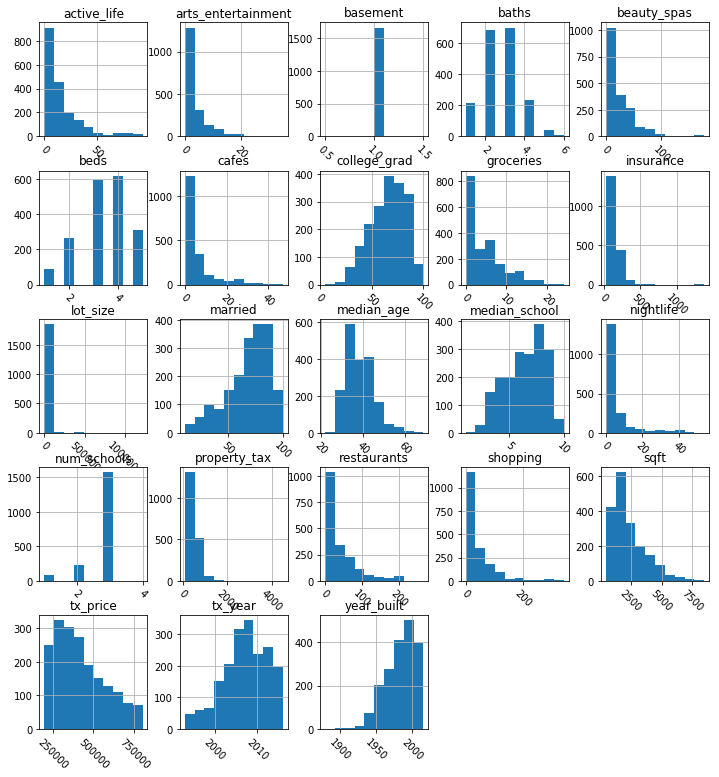

In [7]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12, 13

df.hist(xrot=-45)

plt.show()

In [8]:
df.describe()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1.883000e+03,1657.0,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,422839.807754,3.420605,2.579926,2329.398832,1982.963887,1.339262e+04,1.0,40.210303,4.505045,5.074881,5.325013,40.802443,3.394052,23.416888,15.835369,38.601168,69.091875,65.085502,466.777483,140.454063,6.502921,2.793415,2007.111524
std,151462.593276,1.068554,0.945576,1336.991858,20.295945,4.494930e+04,0.0,46.867012,4.491029,8.464668,7.539309,53.539296,4.699787,25.776916,17.667717,6.634110,19.659767,16.953165,231.656645,72.929765,1.996109,0.505358,5.196898
min,200000.000000,1.000000,1.000000,500.000000,1880.000000,0.000000e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,11.000000,5.000000,88.000000,30.000000,1.000000,1.000000,1993.000000
25%,300000.000000,3.000000,2.000000,1345.000000,1970.000000,1.542000e+03,1.0,7.000000,1.000000,0.000000,0.000000,6.000000,0.000000,4.000000,4.000000,33.000000,58.000000,54.000000,320.000000,94.000000,5.000000,3.000000,2004.000000
50%,392000.000000,3.000000,3.000000,1907.000000,1986.000000,6.098000e+03,1.0,23.000000,3.000000,2.000000,3.000000,22.000000,2.000000,15.000000,10.000000,38.000000,73.000000,66.000000,426.000000,125.000000,7.000000,3.000000,2007.000000
75%,525000.000000,4.000000,3.000000,3005.000000,2000.000000,1.176100e+04,1.0,58.000000,7.000000,6.000000,6.000000,51.000000,5.000000,35.000000,21.000000,43.000000,84.000000,78.000000,569.000000,169.000000,8.000000,3.000000,2011.000000
max,800000.000000,5.000000,6.000000,8450.000000,2015.000000,1.220551e+06,1.0,266.000000,24.000000,54.000000,47.000000,340.000000,35.000000,177.000000,94.000000,69.000000,100.000000,100.000000,4508.000000,1374.000000,10.000000,4.000000,2016.000000


In [9]:
list(df.columns)

['tx_price',
 'beds',
 'baths',
 'sqft',
 'year_built',
 'lot_size',
 'property_type',
 'exterior_walls',
 'roof',
 'basement',
 'restaurants',
 'groceries',
 'nightlife',
 'cafes',
 'shopping',
 'arts_entertainment',
 'beauty_spas',
 'active_life',
 'median_age',
 'married',
 'college_grad',
 'property_tax',
 'insurance',
 'median_school',
 'num_schools',
 'tx_year']

Next, I will try looking at the categorical objects such as **property types, exterior walls** via the use of countplot()

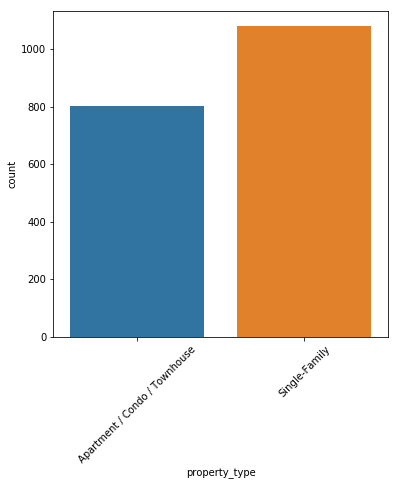

In [10]:
rcParams['figure.figsize']= (6,6)
sns.countplot(x='property_type',data=df)
plt.xticks(rotation=45)
plt.show()

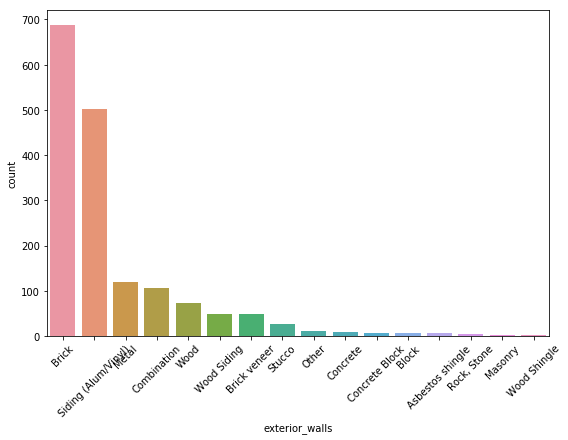

In [11]:
rcParams['figure.figsize']= (9,6)
sns.countplot(x='exterior_walls',data=df,order=df['exterior_walls'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

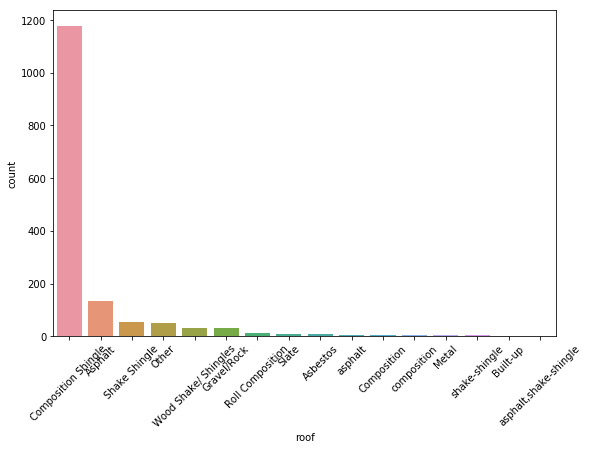

In [12]:
rcParams['figure.figsize']= (9,6)
sns.countplot(x='roof',data=df,order=df['roof'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

These were just simple count plots, it will be more insightful to look at how certain features relates to the property price. A good way to visualize this is through the use of boxplots. Lets see how **property_type** relates to property price for a start.

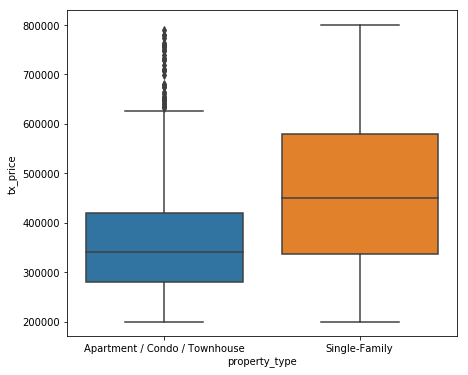

In [13]:
rcParams['figure.figsize']= (7,6)
sns.boxplot(x='property_type',y='tx_price',data=df)
plt.show()

In [14]:
df['tx_price'].groupby(df['property_type']).mean().astype(int)

property_type
Apartment / Condo / Townhouse    366614
Single-Family                    464644
Name: tx_price, dtype: int64

It appears that Single Family property type are generally higher priced as compared to Apartment/Condo/Townhouse

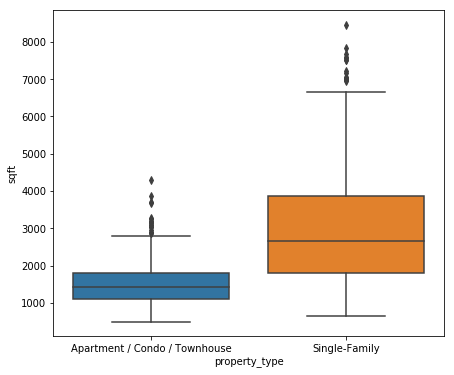

In [15]:
rcParams['figure.figsize']= (7,6)
sns.boxplot(x='property_type',y='sqft',data=df)
plt.show()

From the above boxplot, we can see that **Apartment/Condo/Townhouse** are smaller than **Single Family** homes. We also note that there is greater variation in sizes for **Single Family** homes.

In [16]:
df['sqft'].groupby(df['property_type']).mean()

property_type
Apartment / Condo / Townhouse    1513.727273
Single-Family                    2935.865741
Name: sqft, dtype: float64

Lets examine the correlations between features to have a better understanding of the dataset.

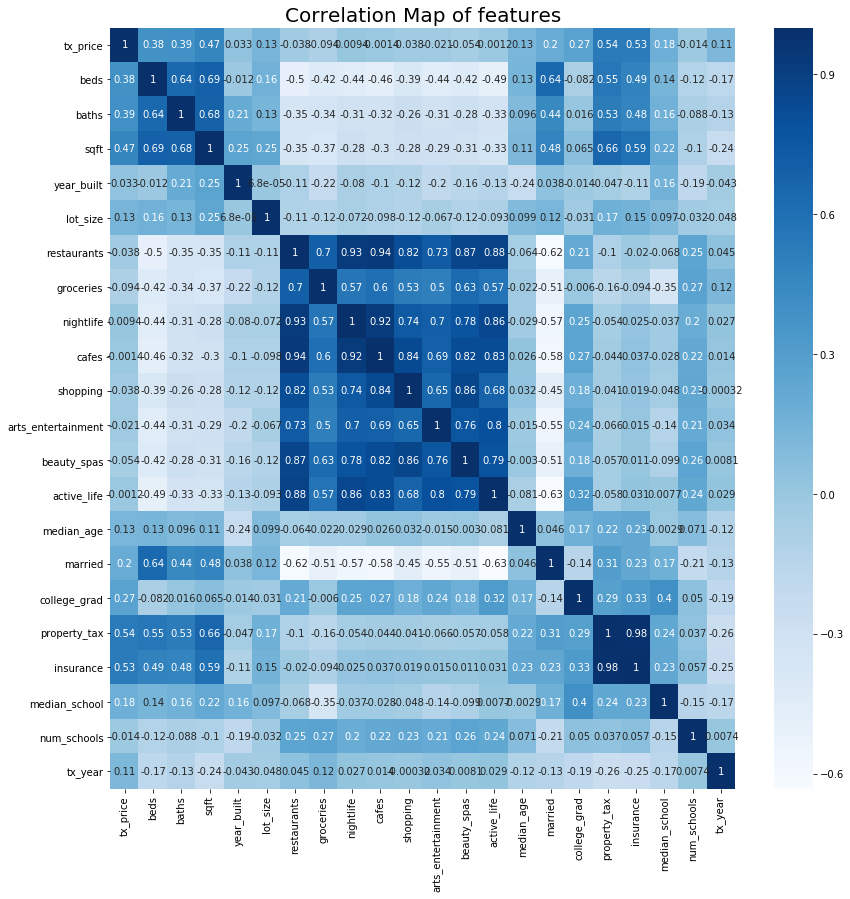

In [42]:
plt.figure(figsize=(14,14))

correlations = df.drop(['basement'],axis=1).corr(method='pearson')

sns.heatmap(correlations,annot=True,cmap='Blues')

plt.title('Correlation Map of features',size=20)

plt.show()

Just looking at the correlation heatmap here, I am already noticing some high intra-correlations between certain features. These highly correlated features may pose a problem with model building due to the issues of multicollinearity. When features are highly correlated with each other, this will make the coeffcient estimates highly unstable which will significantly increase the variance of the predictions.

To mitigate this, I will be running algorithms such as lasso & elastic nets which will help to regularize huge/unstable coefficient estimates.

## Little bit of data cleaning##

The first thing that caught me off when I viewed the scatter plot matrix was the basement variable. It only has counts of ones which is perculiar!

In [17]:
df['basement'].unique()

array([nan,  1.])

No basement is coded as NaN which is not what we wanted. We should be recoding it as 0

In [18]:
df['basement'] = df['basement'].fillna(0)

In [19]:
df['basement'].unique()

array([0., 1.])

In [20]:
df['basement'].value_counts()

1.0    1657
0.0     226
Name: basement, dtype: int64

Next lets drop duplicates!!

In [21]:
print(df.shape)

(1883, 26)


In [22]:
df = df.drop_duplicates()
print(df.shape)

(1883, 26)


It appears that there were no duplicates in this data set.

Now lets fix some typos in the categorical columns

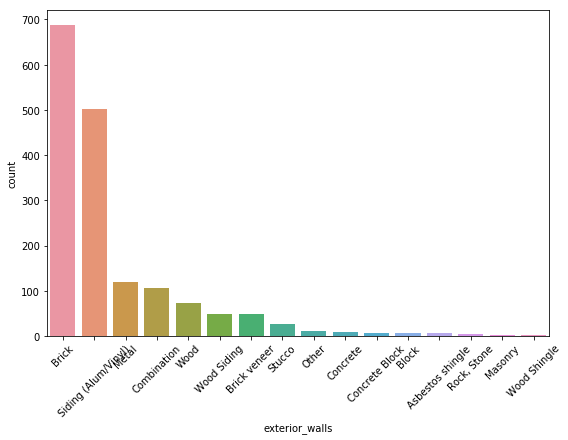

In [23]:
rcParams['figure.figsize']= (9,6)
sns.countplot(x='exterior_walls',data=df,order=df['exterior_walls'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

'Concrete' & 'Block' should be classified under just 'Concrete Block'?

In [24]:
df['exterior_walls'].replace(['Concrete','Block'],'Concrete Block',inplace=True)

df.groupby(['exterior_walls']).size().sort_values()

exterior_walls
Wood Shingle             2
Masonry                  3
Rock, Stone              5
Asbestos shingle         6
Other                   10
Concrete Block          22
Stucco                  26
Brick veneer            48
Wood Siding             49
Wood                    72
Combination            107
Metal                  120
Siding (Alum/Vinyl)    503
Brick                  687
dtype: int64

The counts of **'Concrete Block'** is now 22

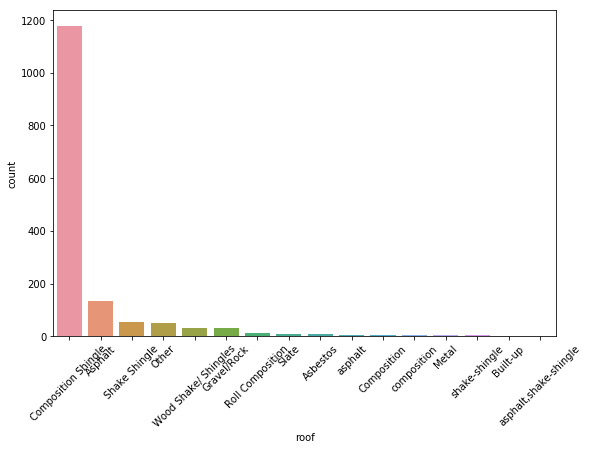

In [25]:
rcParams['figure.figsize']= (9,6)
sns.countplot(x='roof',data=df,order=df['roof'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

Now what do we see? **composition** should be **Composition**, **asphalt** should be **Asphalt**, 


**asphalt,shake-shingle**,**shake-shingle** should be **Shake Shingle**

In [26]:
#Replacing the mispelled words!
df['roof'].replace('asphalt','Asphalt',inplace=True)
df['roof'].replace('composition','Composition',inplace=True)
df['roof'].replace(['shake-shingle','asphalt,shake-shingle'],'Shake Shingle',inplace=True)

In [28]:
df['roof'].value_counts()

Composition Shingle     1179
Asphalt                  137
Shake Shingle             59
Other                     49
Wood Shake/ Shingles      30
Gravel/Rock               30
Roll Composition          12
Slate                      9
Composition                9
Asbestos                   9
Metal                      4
Built-up                   2
Name: roof, dtype: int64

Yipee!!! We have cleared up all the spelling and typo errors :)

## Now lets check for remove outliers

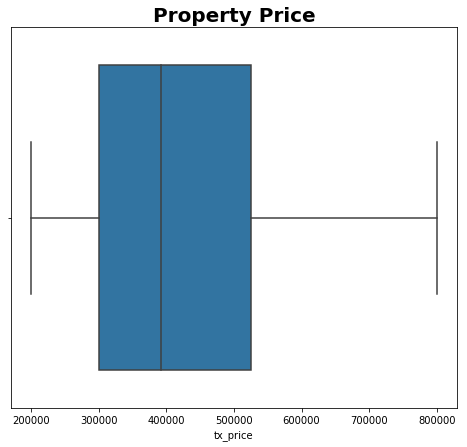

In [29]:
plt.figure(figsize=(8,7))
sns.boxplot(df['tx_price'])

plt.title('Property Price',size=20,fontweight='bold')

plt.show()


In [30]:
df['tx_price'].sort_values(ascending=False).head(15)

1854    800000
1713    800000
854     800000
1122    800000
1436    800000
1461    800000
1447    799223
1624    799000
1855    798000
1520    795000
1655    793260
1593    792000
885     790830
1292    790000
1270    790000
Name: tx_price, dtype: int64

**TX_Price** appears a little positive skewed in the earlier histogram plot,but generally speaking there are no extreme outliers.

In [31]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


Now lets inspect **sqft**

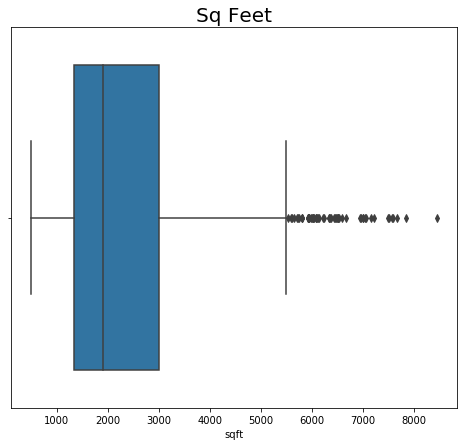

In [32]:
plt.figure(figsize=(8,7))
sns.boxplot(df['sqft'])

plt.title('Sq Feet',size=20)

plt.show()

In [59]:
df['sqft'].sort_values(ascending=False).head(15)

1877    8450
1876    7842
1563    7677
1875    7594
1874    7578
1882    7515
1881    7500
1734    7216
1873    7165
1880    7064
1872    7034
1846    7001
1573    7000
1871    6966
1845    6946
Name: sqft, dtype: int64

It appears that there are some outliers beyond the upper quartile. Let remove the data point where square feet = 8450. I feel there is quite a big jump from the 2nd largest ~ 7842 to the largest square feet.

In [33]:
df = df[df.sqft <= 8000]

df['sqft'].sort_values(ascending=False).head(15)

1876    7842
1563    7677
1875    7594
1874    7578
1882    7515
1881    7500
1734    7216
1873    7165
1880    7064
1872    7034
1846    7001
1573    7000
1871    6966
1845    6946
1844    6662
Name: sqft, dtype: int64

Lets look at **lotsize** too

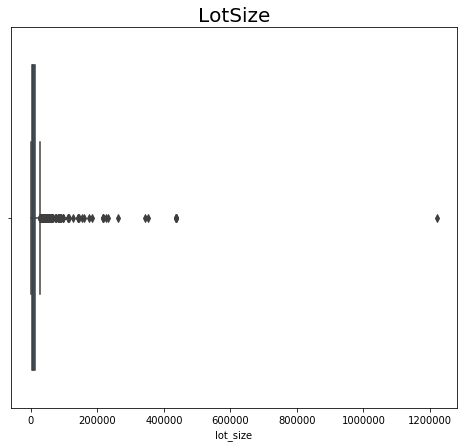

In [34]:
plt.figure(figsize=(8,7))
sns.boxplot(df['lot_size'])

plt.title('LotSize',size=20)

plt.show()

OMG!! This really looks bad, the one outlier at lotsize > 1200000 is causing the boxpot to look so squashed.

In [35]:
df['lot_size'].sort_values(ascending=False).head()

102     1220551
1111     436471
1832     436035
1876     436035
1839     435600
Name: lot_size, dtype: int64

The difference in lot size between the first and second data point as seen in the output table above is too large to be ignored. The lot size of the first data point is at least 2 times the lot size of the second data point. Lets remove the first data point where lot size == 1220551

In [36]:
df = df[df.lot_size <= 500000]

In [37]:
df['lot_size'].sort_values(ascending=False).head()

1111    436471
1876    436035
1832    436035
1115    435600
1817    435600
Name: lot_size, dtype: int64

## Inspecting for missing values

In [38]:
df.select_dtypes(include='int').isnull().sum()

tx_price              0
beds                  0
baths                 0
sqft                  0
year_built            0
lot_size              0
restaurants           0
groceries             0
nightlife             0
cafes                 0
shopping              0
arts_entertainment    0
beauty_spas           0
active_life           0
tx_year               0
dtype: int64

It appears that there are no missing values in the numerical columns

In [39]:
df.select_dtypes(include='object').isnull().sum()

property_type       0
exterior_walls    223
roof              353
dtype: int64

There are so many missing values in the categorical columns ~ **exterior_walls** and **roof**

In [40]:
df['exterior_walls'] = df['exterior_walls'].fillna('Missing')
df['roof'] = df['roof'].fillna('Missing')

In [41]:
df.select_dtypes(include='object').isnull().sum()

property_type     0
exterior_walls    0
roof              0
dtype: int64

We can see that the we have filled up the missing values

## Feature Engineering!

Featuring Engineering is one of the key steps prior to building a model, as it may help improve the model's predictive power. For this project, I am doing it based on my existing domain knowledge as well as intuition.

First of all I would like to create a binary variable which informs me whether the transaction year is during the recession period of 2009 - 2013. The United States was badly hit by the global credit crunch and this period of time was when their economy experienced low & negative growths as well as high unemployment rates.

In [42]:
df['Recession_Period'] = ((df.tx_year>=2010) & (df.tx_year<=2013)).astype(int)

In [43]:
df.groupby(['Recession_Period']).size()

Recession_Period
0    1385
1     496
dtype: int64

We might also be interested in creating a *property age* variable. Intuitively, the property age might possibly have an influence on property transaction price

In [44]:
df['Property_Age'] = df.tx_year - df.year_built


In [45]:
sum(df.Property_Age<0)

18

Lets remove rows whereby Property Age is < 0

In [46]:
df = df[df.Property_Age>=0]

In [47]:
print(df.shape)

(1863, 28)


We obviously lost more observations here, but given that I am uncertain what to do with those data points where **Property Age** is < 0, I chose to delete them.

## Reclassifying sparse class

Looking at the countplots earlier, we can see that there were some sparse classes with some of the categorical variables ~ **roof** and **exterior_walls**.

In [48]:
df.groupby('roof').size()

roof
Asbestos                   9
Asphalt                  136
Built-up                   2
Composition                9
Composition Shingle     1162
Gravel/Rock               30
Metal                      4
Missing                  352
Other                     49
Roll Composition          12
Shake Shingle             59
Slate                      9
Wood Shake/ Shingles      30
dtype: int64

There are some categories with really low counts, so I am thinking of reclassifying them into a broader category

In [49]:
# Group 'Composition' and 'Wood Shake/ Shingles' into 'Composition Shingle'
df.roof.replace(['Composition', 'Wood Shake/ Shingles'], 'Composition Shingle', inplace=True)

In [50]:
# List of classes to group
otherroofs = ['Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Built-up', 'Asbestos', 'Metal']

# Group other classes into 'Others'
df.roof.replace(otherroofs, 'Others', inplace=True)

In [51]:
df.groupby('roof').size()

roof
Asphalt                 136
Composition Shingle    1201
Missing                 352
Others                  115
Shake Shingle            59
dtype: int64

The split in counts across the different roof categories now look so much better. The lesser the categories the better, so I would have lesser columns after I have done one hot encoding.

In [52]:
df.groupby('exterior_walls').size()

exterior_walls
Asbestos shingle         6
Brick                  682
Brick veneer            48
Combination            106
Concrete Block          22
Masonry                  3
Metal                  120
Missing                222
Other                    8
Rock, Stone              5
Siding (Alum/Vinyl)    496
Stucco                  23
Wood                    71
Wood Shingle             2
Wood Siding             49
dtype: int64

I will be reclubbing **Wood Siding**, **Wood Shingle**, **Concrete Block**, **Stucco**, **Masonry**,**Rock, Stone** and **Asbestos Shingle** ~ these are the categories with really low counts and it make sense to club them into broader categories for easier interpretation.

In [53]:
# Group 'Wood Siding' and 'Wood Shingle' with 'Wood'
df.exterior_walls.replace(['Wood Siding', 'Wood Shingle'], 'Wood', inplace=True)

In [54]:
# List of classes to group
other_exterior_walls = ['Concrete Block', 'Stucco', 'Masonry', 'Other', 'Asbestos shingle','Rock, Stone']

# Group other classes into 'Others'
df.exterior_walls.replace(other_exterior_walls, 'Others', inplace=True)

In [55]:
df.groupby('exterior_walls').size()

exterior_walls
Brick                  682
Brick veneer            48
Combination            106
Metal                  120
Missing                222
Others                  67
Siding (Alum/Vinyl)    496
Wood                   122
dtype: int64

This looks much cleaner now :)

## Encoding dummies variables

There is a need to encode dummies variables prior to running the algorithms as most machine learning algorithms do not work on label data directly. Basically, this means that the categorical data must be converted to numerical form. For this data set, as I will just be recoding the categorical predictors, I will be using one hot encoding specifically. The **get_dummies** function from the pandas package comes in handy.

In [56]:
df = pd.get_dummies(df,columns=['property_type','exterior_walls','roof'])

In [57]:
df.head(10)

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,Recession_Period,Property_Age,property_type_Apartment / Condo / Townhouse,property_type_Single-Family,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Others,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Others,roof_Shake Shingle
0,295850,1,1,584,2013,0,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,216500,1,1,612,1965,0,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,0,41,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,279900,1,1,615,1963,0,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,1,49,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,379900,1,1,618,2000,33541,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,340000,1,1,634,1992,0,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,0,10,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,265000,1,1,641,1947,0,0.0,146,10,23,27,86,9,60,52,28.0,15.0,86.0,168.0,58.0,8.0,3.0,2004,0,57,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,240000,1,1,642,1944,0,0.0,159,13,36,17,92,12,66,50,28.0,36.0,88.0,176.0,61.0,7.0,3.0,2011,1,67,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
7,388100,1,1,650,2000,33541,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,266.0,92.0,9.0,3.0,2005,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
8,240000,1,1,660,1983,0,0.0,51,8,6,2,40,18,32,41,36.0,49.0,77.0,188.0,65.0,6.0,3.0,2013,1,30,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,250000,1,1,664,1965,0,0.0,119,10,26,25,183,13,70,36,57.0,13.0,83.0,147.0,51.0,6.0,3.0,2007,0,42,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Next drop those irrelevant columns prior to the data modelling phrase

In [58]:
df = df.drop(['tx_year','year_built'],axis=1)

In [59]:
df.head()

,tx_price,beds,baths,sqft,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,Recession_Period,Property_Age,property_type_Apartment / Condo / Townhouse,property_type_Single-Family,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Others,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Others,roof_Shake Shingle
0,295850,1,1,584,0,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,216500,1,1,612,0,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,0,41,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,279900,1,1,615,0,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,1,49,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,379900,1,1,618,33541,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,0,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,340000,1,1,634,0,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,0,10,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Now lets start doing some modelling. I shall begin with a linear regression just to gauge the predictive error via the **MAE**.

## Linear Regression

In [60]:
import statsmodels.formula.api as smf

In [61]:
X = df.drop('tx_price',axis = 1)
y = df['tx_price']

In [62]:
print(X.shape)
print(y.shape)

(1863, 37)
(1863,)


Import relevant package modules such as *train_test_split* as well as *LinearRegression*.

In [63]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)


linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

In [64]:
print(metrics.mean_absolute_error(y_pred,y_test))

93347.63041493674


The prediction error is on average $93k off. Lets try other regularized regressions.

I will be using sklearn's pipeline to try out the regularized regression algorithms. This keeps my codes simpler.

## Regularized Regressions - via sklearn pipeline

In [65]:
#Function for creating model pipelines
from sklearn.pipeline import make_pipeline

#For standardization
from sklearn.preprocessing import StandardScaler

#Import regularised regressions module
from sklearn.linear_model import ElasticNet, Ridge, Lasso

In [68]:
#Creating the pipeline :)

pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=1234)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=1234)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=1234))
}

In [70]:
#Testing to see whether it works?
for key, value in pipelines.items():
    print (key,value)

lasso Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1234,
   selection='cyclic', tol=0.0001, warm_start=False))])
ridge Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1234, solver='auto', tol=0.001))])
enet Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1234, selection='cyclic', tol=0.0001, warm_start=False))])


The above is a pipeline dictionary which store each respective model instances within it. The next important step is to set up some parameters to tune for the Ridge, Lasso and Elastic net models.

In [71]:
# Lasso hyperparameters
lasso_parameters = { 
    'lasso__alpha' : [0.01, 0.05, 0.1, 0.5, 1] 
}

# Ridge hyperparameters
ridge_parameters = { 
    'ridge__alpha': [0.01, 0.05, 0.1, 0.5, 1]  
}

# Elastic Net hyperparameters
enet_parameters = { 
    'elasticnet__alpha': [0.01, 0.05, 0.1, 0.5, 1],                        
    'elasticnet__l1_ratio' : [0.1,0.3, 0.5, 0.7, 0.9]  
}


Note that I have to tune for two different parameters for Elastic Net. One of which is the **alpha** that is some sort of a shrinkage penalty to regulate the size of the regression coefficients, while the other is the **l1 ratio** which "controls" the extent of how ridge or lasso - like the model will be. This ratio parameter linearly combines both the L1 & L2 penalties together.

In [72]:
# Create hyperparameters dictionary
parameters = {
    'lasso' : lasso_parameters,
    'ridge' : ridge_parameters,
    'enet' : enet_parameters
}

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
fittedmodel = {}

for modelname, pipeline in pipelines.items():
    model = GridSearchCV(pipeline,parameters[modelname],cv=5,n_jobs=-1)
    model.fit(X_train,y_train)
    fittedmodel[modelname] = model
    print(modelname,'has been fitted')
   

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

lasso has been fitted


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ridge has been fitted


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

enet has been fitted


Next, lets print the holdout R2 from cross validation for each of the fitted models.

In [77]:
for modelname, model in fittedmodel.items():
    print(modelname,model.best_score_)

lasso 0.3786982157864105
ridge 0.3789576360603392
enet 0.385684465797971


In [78]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [79]:
for modelname,model in fittedmodel.items():
    pred = model.predict(X_test)
    print(modelname)
    print('R^2',r2_score(y_test,pred))
    print('MAE',mean_absolute_error(y_test,pred))
    

lasso
R^2 0.2933052832219696
MAE 93346.54122698313
ridge
R^2 0.293712843123917
MAE 93350.85300052016
enet
R^2 0.31704743803754354
MAE 93245.19910530743


Seems that the elastic net is performing better than either the ridge or lasso regression for both metrics using the test dataset, but albeit only slightly better.

## Random Forest

The idea behind random forest is that it is basically an ensemble technique which mitigates the problem of underfitting/overfitting especially when we are just relying solely on a single model. Essentially, it improves the predictive accuracy of a single model by generating lots of model on the training dataset and then combining/averaging at the end. By averaging, this helps to reduce the variance and hence improve the performance of the algorithm on the testing dataset.

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
grid_params = {'n_estimators':[50,100,150,200,250,300]}
fixed_params = {'random_state':1234,'n_jobs':-1}

In [83]:
#Lets tune for the optimum number of trees first
gridsearchRF = GridSearchCV(RandomForestRegressor(**fixed_params),param_grid=grid_params,cv=5,n_jobs=-1,
                            scoring='neg_mean_absolute_error')

In [84]:
gridsearchRF.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [85]:
gridsearchRF.best_params_

{'n_estimators': 200}

It appears that the optimum number of trees required would be 200. Now lets tune for the other parameters such as **max_depth** and **min_samples_split**.

In [86]:
grid_params = {'max_depth':[10,20,30,40,50],
              'min_samples_split':[5,10,15]}
fixed_params = {'n_estimators':200,'random_state':1234,'n_jobs':-1}

In [87]:
gridsearchRF = GridSearchCV(RandomForestRegressor(**fixed_params),param_grid=grid_params,cv=5,n_jobs=-1,
                           scoring='neg_mean_absolute_error')

In [88]:
gridsearchRF.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [89]:
gridsearchRF.best_params_

{'max_depth': 10, 'min_samples_split': 15}

In [90]:
rf_model = RandomForestRegressor(**fixed_params,**gridsearchRF.best_params_)
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [91]:
y_pred = rf_model.predict(X_test)

In [92]:
mean_absolute_error(y_test,y_pred)

76269.69543108915

The prediction results from the random forest model is a big improvement from that of the regularized regression's predictions. The prediction error was on average off by 90K previously, but this time round it is off by only about 76K.

The table below shows the feature importance of the various predictor variables used in the random forest model. We can see that the monthly insurance as well as the property tax are really important predictors of the property transaction price. This makes sense intuitively.

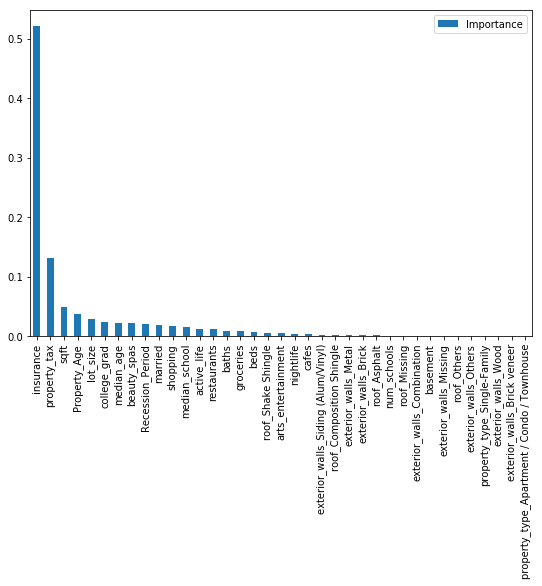

In [132]:
rcParams['figure.figsize']= (9,6)
pd.DataFrame(rf_model.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False).plot(kind='bar')
plt.show()

## Extreme Gradient Boosting

XGB is basically a variant of the traditional gradient boosting algorithm. However it is a known fact that gradient boosting is essentially a very greedy algorithm as it works to minimise residual loss function with each sucessive additions of weaker trees submodels. XGB uses a more regularised model framework,to help smooth the final learning rates in order to correct for over fitting.

In [4]:
import xgboost as xgb
from xgboost import XGBRegressor

In [134]:
grid_params = {'n_estimators':[50,100,150,200,250,300]}
fixed_params = {'random_state':1234,'n_jobs':-1}

In [136]:
gridsearchXGB = GridSearchCV(XGBRegressor(**fixed_params),param_grid=grid_params,cv=5,n_jobs=-1,
                            scoring='neg_mean_absolute_error')

In [138]:
gridsearchXGB.fit(X_train,y_train)
print(gridsearchXGB.best_params_)

{'n_estimators': 100}


Apparently, 100 trees is deemed sufficient when using XGBoost

In [139]:
grid_params = {'max_depth':[10,20,30,40,50],
              'min_child_weight':[5,10,15],
              'learning_rate':[0.025,0.05,0.07,0.1]}
fixed_params = {'n_estimators':100,'random_state':1234,'n_jobs':-1}

In [140]:
gridsearchXGB = GridSearchCV(XGBRegressor(**fixed_params),param_grid=grid_params,cv=5,n_jobs=-1,
                            scoring='neg_mean_absolute_error')

In [142]:
gridsearchXGB.fit(X_train,y_train)
print(gridsearchXGB.best_params_)

{'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 15}


In [143]:
xgb_model = XGBRegressor(max_depth=20,min_child_weight=15,learning_rate=0.05,n_estimators=100,random_state=1234,n_jobs=-1)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=20, min_child_weight=15, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=1234,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [144]:
y_pred = xgb_model.predict(X_test)

In [145]:
print(mean_absolute_error(y_test,y_pred))

77010.74714892666


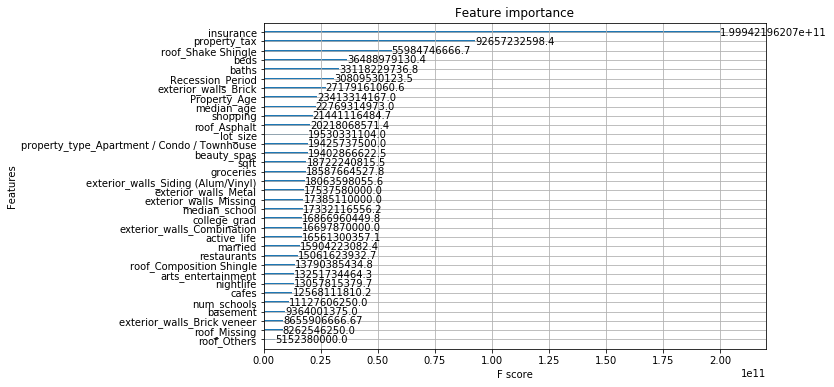

In [146]:

xgb.plot_importance(xgb_model,importance_type='gain')
plt.show()

The mean absolute error on the test set is 77K off, which means that the XGBoost algorithm's performance is below that of random forest. This is rather surprising to me, as boosted trees algorithms add new sub tree models to compliment existing trees, so technically speaking, this should give me a better accuracy. Perhaps I could possibly experiment with a lower learning rate to effectively allow more trees to be added to the model, hence improving the predictions?